## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
from sklearn.datasets import load_iris
from io import StringIO  
iris = load_iris()
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pydotplus

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

dot_data = StringIO()

filename = "model.png"
featureNames = iris.feature_names 

targetNames = iris.target_names
out=tree.export_graphviz(estimator,feature_names=featureNames, out_file=dot_data, class_names= targetNames, filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(200, 200))
plt.imshow(img,interpolation='nearest');

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
# check actual name of birth year column
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state'],
      dtype='object')

In [8]:
# check data types to see if it is actually typed as a date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [9]:
# it's a float!
df.birth_year.head()

0    1964.0
1    1987.0
2    1964.0
3    1991.0
4    1992.0
Name: birth_year, dtype: float64

In [10]:
# convert to date

df['birth_date'] = pd.to_datetime(df.birth_year, format='%Y', exact=True)

In [11]:
# now its a date

df.birth_date.head()

0   1964-01-01
1   1987-01-01
2   1964-01-01
3   1991-01-01
4   1992-01-01
Name: birth_date, dtype: datetime64[ns]

In [12]:
# use datetime attributes to calculate age

from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [13]:
df['n_age'] = df.birth_date.apply(calculate_age)


In [14]:
df.n_age

0       56.0
1       33.0
2       56.0
3       29.0
4       28.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [15]:
for col in df.columns:
    print(col, (df[col].isnull().sum()))

patient_id 0
global_num 904
sex 145
birth_year 454
age 261
country 0
province 0
city 65
disease 2199
infection_case 1055
infection_order 2176
infected_by 1749
contact_number 1807
symptom_onset_date 2025
confirmed_date 141
released_date 1995
deceased_date 2186
state 88
birth_date 454
n_age 454


 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [16]:
# Create filters for null and not null

null = df.disease.isnull()

In [17]:
notnull = df.disease.notnull()

In [18]:
# Replace null values with zero and not null values with one

df.loc[null,'disease'] = 0

In [19]:
df.loc[notnull,'disease'] = 1

In [20]:
# Check disease column
df.disease.head()

0    0
1    0
2    0
3    0
4    0
Name: disease, dtype: object

In [21]:
# Check that the not null values match the original count

len(df.disease[df.disease == 1])

19

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [22]:
# Get correct column names

df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'birth_date', 'n_age'],
      dtype='object')

In [23]:
# mean imputation
df.global_num = df.global_num.fillna(np.mean(df.global_num))
# check if any null values are left
df.global_num.isnull().any()

False

In [24]:
# calculate mean year
mean_year = round(df.birth_year.mean())
mean_year

1975

In [25]:
# substitute null values with mean year
df.birth_year = df.birth_year.fillna(mean_year)
df.birth_year.isnull().any()

False

In [26]:
df.birth_year.head()

0    1964.0
1    1987.0
2    1964.0
3    1991.0
4    1992.0
Name: birth_year, dtype: float64

In [27]:
# more mean imputations
df.infection_order = df.infection_order.fillna(np.mean(df.infection_order))
df.infection_order.isnull().any()

False

In [28]:
df.infected_by = df.infected_by.fillna(np.mean(df.infected_by))
df.infected_by.isnull().any()

False

In [29]:
df.contact_number = df.contact_number.fillna(np.mean(df.contact_number))
df.contact_number.isnull().any()

False

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [30]:
# Let's check which columns still have null values
for col in df.columns:
    print(col, (df[col].isnull().sum()))

patient_id 0
global_num 0
sex 145
birth_year 0
age 261
country 0
province 0
city 65
disease 0
infection_case 1055
infection_order 0
infected_by 0
contact_number 0
symptom_onset_date 2025
confirmed_date 141
released_date 1995
deceased_date 2186
state 88
birth_date 454
n_age 454


In [31]:
# mean imputation for n_age
df.n_age = df.n_age.fillna(np.mean(df.n_age))
df.n_age.isnull().any()

False

In [32]:
# mode imputations for categorical columns
df.sex = df.sex.fillna(df.sex.mode()[0])
df.sex.isnull().any()

False

In [33]:
df.infection_case = df.infection_case.fillna(df.infection_case.mode()[0])
df.infection_case.isnull().any()

False

In [34]:
# set not null values to date times
notnull2 = df.symptom_onset_date.notnull()

In [35]:
df.loc[notnull2,'symptom_onset_date'] = pd.to_datetime(df.loc[notnull2,'symptom_onset_date'], infer_datetime_format=True, errors='coerce')

In [36]:
# Least possible date imputation since these were nan 
df.symptom_onset_date = df.symptom_onset_date.fillna(pd.to_datetime(df.symptom_onset_date.fillna(pd.Timestamp.min.ceil('D'))))

In [37]:
# Check for nulls
df.symptom_onset_date
df.symptom_onset_date.isnull().any()

False

In [38]:
# label variable substitute nulls with 'missing' since we actually don't know

df.state = df.state.fillna('missing')
df.state.isnull().any()

False

In [39]:
# more least possible date imputations since these were also nan values and seem important

cols = ['confirmed_date', 'released_date', 'deceased_date']

for col in cols:
    # set not null values to date times
    notnull2 = df[col].notnull()
    df.loc[notnull2,col] = pd.to_datetime(df.loc[notnull2,col], infer_datetime_format=True, errors='coerce')
    # Least possible date imputation
    df[col] = df[col].fillna(pd.to_datetime(df[col].fillna(pd.Timestamp.min.ceil('D'))))

In [40]:
# check what's left

for col in df.columns:
    print(col, (df[col].isnull().sum()))

patient_id 0
global_num 0
sex 0
birth_year 0
age 261
country 0
province 0
city 65
disease 0
infection_case 0
infection_order 0
infected_by 0
contact_number 0
symptom_onset_date 0
confirmed_date 0
released_date 0
deceased_date 0
state 0
birth_date 454
n_age 0


In [41]:
# This column was auxiliary only - not part of the original data set, we have the complete
# birth_year column already so we are dropping this one
df.drop('birth_date', axis=1, inplace=True)

In [42]:
# Let's see what cities are null
df[df['city'].isnull()].head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
288,1100000007,4664.816591,male,1994.0,20s,China,Busan,NaN,0,Shincheonji Church,2.285714,2.600789e+09,485.000000,1677-09-22,2020-02-22,1677-09-22,1677-09-22,isolated,26.0
383,1200000031,31.000000,female,1959.0,60s,Korea,Daegu,NaN,0,Shincheonji Church,2.285714,2.600789e+09,1160.000000,1677-09-22,2020-02-18,1677-09-22,1677-09-22,isolated,61.0
394,1200000047,47.000000,female,1957.0,60s,Korea,Daegu,NaN,0,Shincheonji Church,2.285714,1.200000e+09,24.128954,1677-09-22,2020-02-19,1677-09-22,1677-09-22,isolated,63.0
395,1200000048,48.000000,female,1948.0,70s,Korea,Daegu,NaN,0,Shincheonji Church,2.285714,1.200000e+09,24.128954,1677-09-22,2020-02-19,1677-09-22,1677-09-22,isolated,72.0
396,1200000049,49.000000,male,1962.0,50s,Korea,Daegu,NaN,0,Shincheonji Church,2.285714,1.200000e+09,24.128954,1677-09-22,2020-02-19,1677-09-22,1677-09-22,isolated,58.0


In [43]:
# Which city is the most probable based on count

df[df['province'] == 'Busan']['city'].value_counts()


Dongnae-gu      29
Haeundae-gu     17
Busanjin-gu     11
Suyeong-gu       8
Saha-gu          7
Seo-gu           6
etc              4
Geumjeong-gu     4
Yeonje-gu        4
Gangseo-gu       3
Buk-gu           3
Nam-gu           2
Sasang-gu        2
Name: city, dtype: int64

In [44]:
df.loc[df['province'] == 'Busan','city'].head()

282     Dongnae-gu
283    Haeundae-gu
284    Haeundae-gu
285    Haeundae-gu
286    Haeundae-gu
Name: city, dtype: object

In [45]:
# substitute nulls with most probable cities
df.loc[df['province'] == 'Busan','city']='Dongnae-gu'

In [46]:
df[df['province']=='Busan']['city'].isnull().head()

282    False
283    False
284    False
285    False
286    False
Name: city, dtype: bool

In [47]:
df[df['province'] == 'Daegu']['city'].value_counts()

Nam-gu          8
Dalseo-gu       4
Jung-gu         3
Seo-gu          2
Suseong-gu      2
Dong-gu         1
Dalseong-gun    1
Name: city, dtype: int64

In [48]:
df.loc[df['province'] == 'Daegu','city'] = 'Nam-gu'

In [49]:
df[df['province'] == 'Jeollanam-do']['city'].value_counts()

Gwangyang-si    1
Suncheon-si     1
Yeosu-si        1
Name: city, dtype: int64

In [50]:
# just pick one 1/3 probability each
df.loc[df['province']  == 'Jeollanam-do','city'] ='Gwangyang-si'

In [51]:
df[df['province'] == 'Gyeongsangnam-do']['city'].value_counts()

Changwon-si        21
Geochang-gun       19
Changnyeong-gun     9
Hapcheon-gun        8
Gimhae-si           6
Geoje-si            6
Miryang-si          5
Yangsan-si          2
Goseong-gun         2
Jinju-si            2
Namhae-gun          1
Hamyang-gun         1
Name: city, dtype: int64

In [52]:
df.loc[df['province']  == 'Gyeongsangnam-do','city'] = 'Changwon-si'

In [53]:
df[df['province'] == 'Gyeongsangnam-do']['city'].head()

2129    Changwon-si
2130    Changwon-si
2131    Changwon-si
2132    Changwon-si
2133    Changwon-si
Name: city, dtype: object

In [54]:
# check again
for col in df.columns:
    print(col, (df[col].isnull().sum()))

patient_id 0
global_num 0
sex 0
birth_year 0
age 261
country 0
province 0
city 18
disease 0
infection_case 0
infection_order 0
infected_by 0
contact_number 0
symptom_onset_date 0
confirmed_date 0
released_date 0
deceased_date 0
state 0
n_age 0


In [55]:
df[df['city'].isnull()]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
446,1300000001,16.000000,female,1975.0,40s,Korea,Gwangju,NaN,0,contact with patient,2.285714,2.600789e+09,450.0,2020-01-27,2020-02-04,2020-02-20,1677-09-22,released,45.011338
447,1300000002,18.000000,female,1975.0,20s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,8.0,1677-09-22,2020-02-05,2020-02-20,1677-09-22,released,45.011338
448,1300000003,126.000000,male,1975.0,30s,Korea,Gwangju,NaN,0,etc,2.285714,2.600789e+09,65.0,1677-09-22,2020-02-20,1677-09-22,1677-09-22,isolated,45.011338
449,1300000004,164.000000,male,1975.0,30s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,30.0,1677-09-22,2020-02-21,2020-03-18,1677-09-22,released,45.011338
450,1300000005,210.000000,male,1975.0,30s,Korea,Gwangju,NaN,0,etc,2.285714,2.600789e+09,156.0,1677-09-22,2020-02-21,2020-03-16,1677-09-22,released,45.011338
451,1300000006,239.000000,male,1975.0,30s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,14.0,1677-09-22,2020-02-21,2020-03-16,1677-09-22,released,45.011338
452,1300000007,489.000000,male,1975.0,30s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,39.0,1677-09-22,2020-02-22,2020-03-17,1677-09-22,released,45.011338
453,1300000008,589.000000,female,1975.0,30s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,47.0,1677-09-22,2020-02-22,2020-03-06,1677-09-22,released,45.011338
454,1300000009,611.000000,female,1975.0,30s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,0.0,1677-09-22,2020-02-23,2020-03-19,1677-09-22,released,45.011338
455,1300000010,4388.000000,female,1975.0,40s,Korea,Gwangju,NaN,0,contact with patient,2.285714,1.300000e+09,86.0,1677-09-22,2020-03-02,1677-09-22,1677-09-22,isolated,45.011338


In [56]:
df[df['province'] == 'Gwangju']['city'].value_counts()

Series([], Name: city, dtype: int64)

In [57]:
# no other cities in the province, according to google, Gwangju is a city, a metropolitan area
# we will make the assumption the entire area is the city
df.loc[df['province']  == 'Gwangju','city'] = 'Gwangju'

In [58]:
# one more check
for col in df.columns:
    print(col, (df[col].isnull().sum()))

patient_id 0
global_num 0
sex 0
birth_year 0
age 261
country 0
province 0
city 0
disease 0
infection_case 0
infection_order 0
infected_by 0
contact_number 0
symptom_onset_date 0
confirmed_date 0
released_date 0
deceased_date 0
state 0
n_age 0


In [59]:
df.age.head()

0    50s
1    30s
2    50s
3    20s
4    20s
Name: age, dtype: object

In [60]:
# Categorical variable use mode substitution
df.age = df.age.fillna(df.age.mode()[0])
df.age.isnull().any()

False

In [61]:
# one more check
for col in df.columns:
    print(col, (df[col].isnull().sum()))

patient_id 0
global_num 0
sex 0
birth_year 0
age 0
country 0
province 0
city 0
disease 0
infection_case 0
infection_order 0
infected_by 0
contact_number 0
symptom_onset_date 0
confirmed_date 0
released_date 0
deceased_date 0
state 0
n_age 0


 **<font color='teal'> Check for any remaining null values.</font>**

In [62]:
df.isnull().any()

patient_id            False
global_num            False
sex                   False
birth_year            False
age                   False
country               False
province              False
city                  False
disease               False
infection_case        False
infection_order       False
infected_by           False
contact_number        False
symptom_onset_date    False
confirmed_date        False
released_date         False
deceased_date         False
state                 False
n_age                 False
dtype: bool

Remove date columns from the data.


In [63]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [64]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           96
age                  11
country               4
province             17
city                112
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                97
dtype: int64


Review the percent of unique values by column.

In [65]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043282
age                0.004959
country            0.001803
province           0.007665
city               0.050496
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043733
dtype: float64


Review the range of values per column.

In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974991e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.975000e+03,1.988000e+03,2.020000e+03
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [67]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [68]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,112
5,disease,2
6,infection_case,16
7,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<AxesSubplot:>

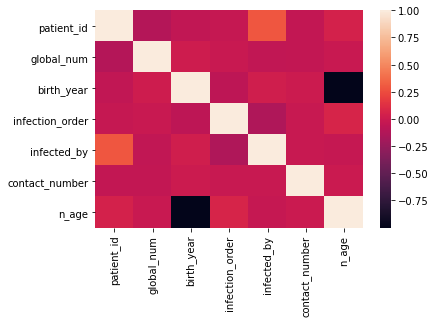

In [69]:
sns.heatmap(df.corr())

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [70]:
#check columns again
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age'],
      dtype='object')

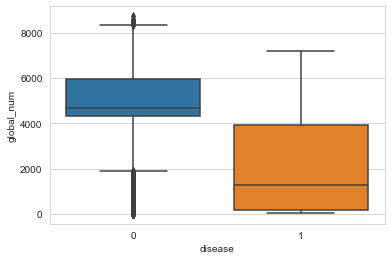

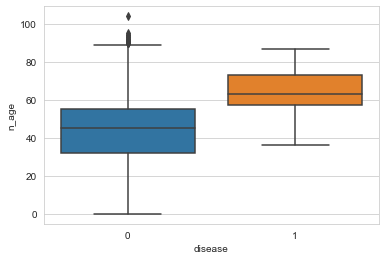

In [71]:
# There are outliers on the 'disease = 0' category for global num and n_age, global num 
# outliers are part of the provided data since our imputation only included the mean
# meaning there are very large counts vs very low counts which we will
# explore further below and, regarding the age data,
# there are some unusually older people that did not get sick.

cat_cols = ['global_num','n_age']

def plot_box(df, cols, col_x = 'disease'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col_x, col, data=df)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

plot_box(df, cat_cols)

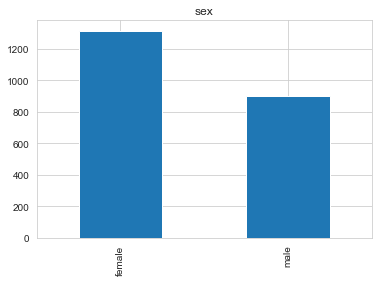

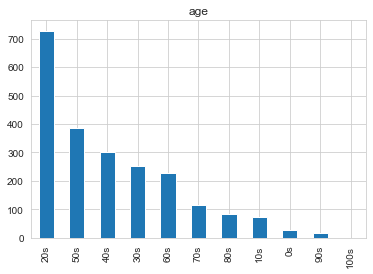

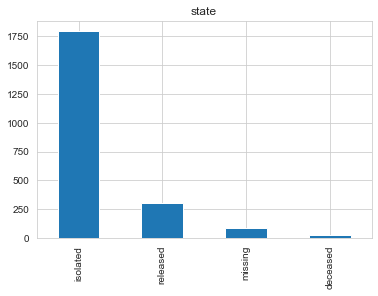

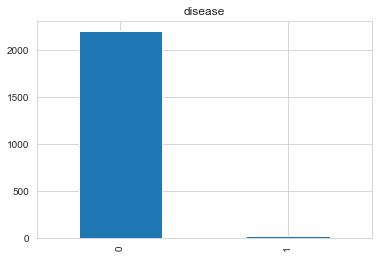

In [72]:
# We can use categorical counts to more easily see how
# gender, age, infection cases and state of patients
# are distributed

# More female patients than male patients
# There were many more patients in their 20s
# Many more patients were isolated than released, missing or deceased
# There is a very small number of deceased patients compared to other classes
# There were many more patients that did not have
# the disease vs those that did

cols = ['sex', 'age','state','disease']
for col in cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

<AxesSubplot:>

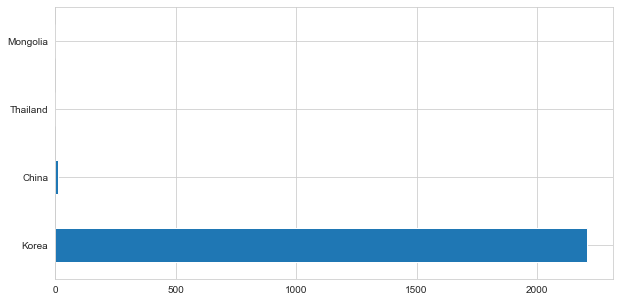

In [73]:
# There were many more patients from Korea than other countries

df.country.value_counts().plot(kind='barh', figsize=(10,5))

<AxesSubplot:>

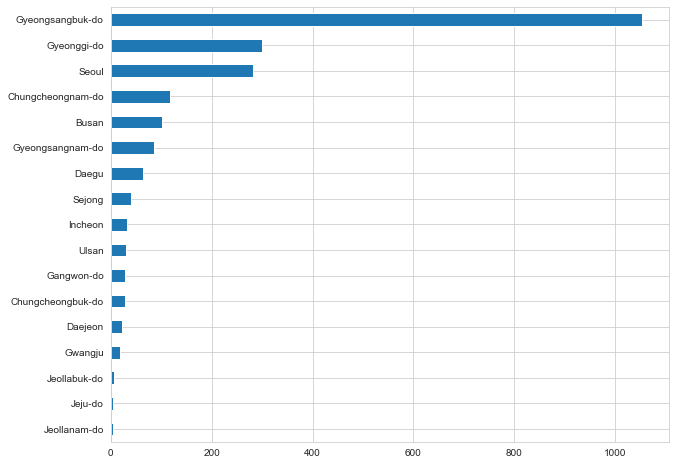

In [74]:
# There were many more patients from the province of Gyeongsangbuk-do than other provinces

df.province.value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10,8))

<AxesSubplot:>

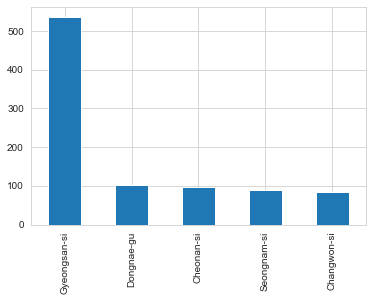

In [75]:
# from the cities Gyeongsan-si had the largest patient count (over 500)

df.city.value_counts().head().plot(kind='bar')

<AxesSubplot:>

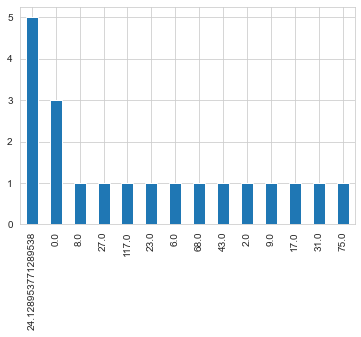

In [76]:
# contact number contains many small and distinct decimal numbers grouped together 
# in counts of 5 or less, with 24.128... having the largest count of 5

df.contact_number.head(20).value_counts().plot(kind='bar')

<AxesSubplot:>

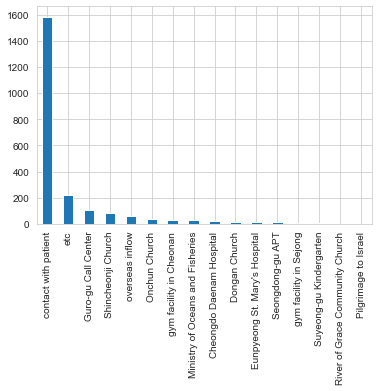

In [77]:
# For infection cases, contact with patient had the largest category count


df.infection_case.value_counts().plot(kind='bar')

**<font color='teal'> Create dummy features for object type features. </font>**

In [78]:
# let's separate our label variable first
df['state'].value_counts()
y=df[['state']]

In [79]:
# ordinal encode target variable
from sklearn.preprocessing import OrdinalEncoder


label_encoder = OrdinalEncoder()
y = label_encoder.fit_transform(y)
y = y.ravel()

In [80]:
# now use get_dummies on the features

X = df.drop('state', axis=1)
X = pd.get_dummies(X, drop_first=True)

### Split the data into test and train subsamples

In [81]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [82]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [83]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [84]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.847
Random Forest: f1-score=0.812


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [85]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0   0]
 [  0 342   0   9]
 [  0   1  16   0]
 [  0  57   0  12]]
Normalized confusion matrix
[[0.86 0.14 0.   0.  ]
 [0.   0.97 0.   0.03]
 [0.   0.06 0.94 0.  ]
 [0.   0.83 0.   0.17]]


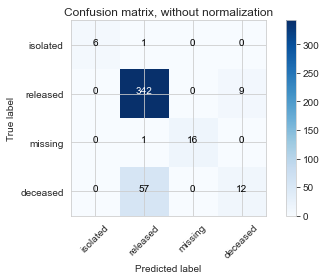

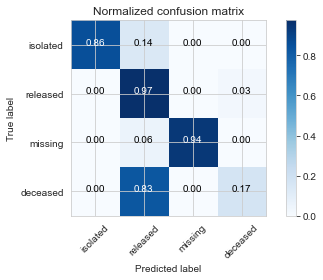

In [86]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


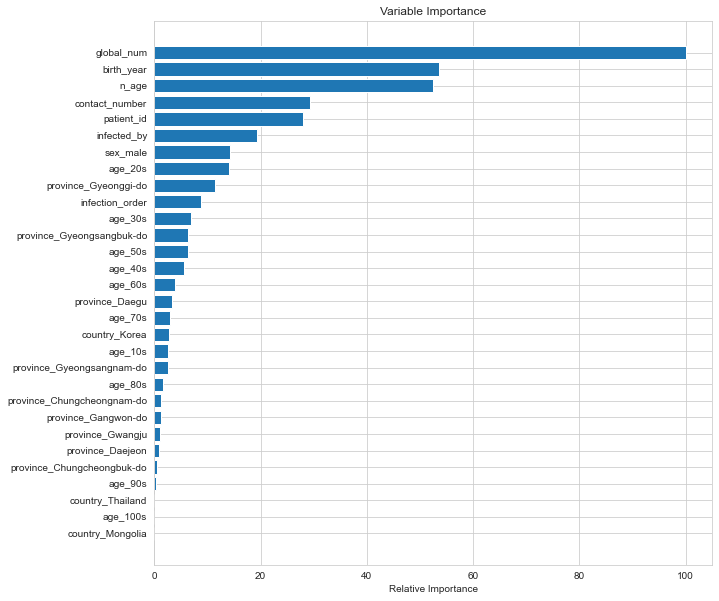

In [87]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.